###Pseudocode
1. **Import needed modules:**`numpy` for linear algebra and special functions, `matplotlib.pyplot` for plotting, `scipy.integrate.solve-ivp` for solving the ODE, and `scipy.integrate.quad` for integration.
2. **Define ODE function and integrand:** `rigid_pendulum_ode` represents the ODE function, `period_integrand` is the integrand function.
3. **Create Utilities:** `basic_plot` for simple pyplot plotting.
4. **Extracting the period:** `extract_period_ode` uses the *solve_ivp* approach, and `extract_period_int` uses the integral, *quad*, approach.
5. **Plot T vs $\omega_0$ using both approaches:** `theta_pi_event` is used with *solve_ivp* to approximate the period. `theta_rev_event` is also used with *solve_ivp* to calculate the revoltion time. Plotting $T$ and $T_{rev}$ vs $\omega_0$ allows us to see our approaches. As $T$ and $T_{rev}$ are both units of seconds, we can plot them on the same mesh.


In [37]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

In [38]:
#define utilities
def basic_plot(x,y,xlabel=None,ylabel=None,figsize=(3,3)): #plotting utility
  """
  Inputs:
    x -       domain
    y -       range
    xlabel -  title for x axis
    ylabel -  title for y axis
    figsize - size of the graph
  Returns:
    Matplotlib Graph
  """
  plt.figure(figsize=figsize)
  plt.plot(x,y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  return plt.show()
#define functions
def rigid_pendulum_ode(t,y,omega_0 = 1):
  ang_vel, theta = y                       #unpack state variables
  dangvel_dt = -omega_0**2 * np.sin(theta) #first derivative
  dtheta_dt = ang_vel                      #second derivative
  dy_dt = [dangvel_dt,dtheta_dt]           #derivative of the state variable
  return dy_dt
def period_integrand(omega,omega_0,omega_init):
  """
  Inputs:
    omega      - angular velocity
    omega_0    - natural frequency
    omega_init - initial angular velocity
  Returns:
    Value of the expression at given variables
  """
  expr = 1 - (omega_init**2 - omega**2) / (2 * omega_0**2)
  return 1 / (omega_0**2 * np.sqrt(1 - expr**2))


def theta_pi_event(t,y,omega_0=1):
  """
  Event Function--
  Returns: a numpy array containing when theta is equal to pi, or every half period.
  """
  return np.mod(y[1],2*np.pi)- np.pi
theta_pi_event.terminal = False
def theta_rev_event(t,y,omega_0=1.0):
  """
  Event function--
  Returns: a numpy array containing when theta increases by a multiple of 2pi

  """
  ang_vel,theta = y #unpack state variables
  return np.sin(theta/2)
theta_rev_event.terminal = False
theta_rev_event.direction = +1

def extract_period_int(n_points, eps=1e-3,omega_0=1):
  """
  """
  omega_init_list = np.linspace(eps,np.pi-eps,n_points) #list of initial angular velocities
  period_list_int = []                                  #initialize list
  for omega_init in omega_init_list:
    period, err = quad(period_integrand,0,omega_init-eps,args=(omega_0,omega_init),epsabs=1e-6,epsrel=1e-6)
    period_list_int.append(4*period)                    #4 multiplication due to the period
  return omega_init_list, np.array(period_list_int)

def extract_period_ode(n_points=100,omega_0=1):
  """
  Inputs-
  n_points : How many data values we want for calculation
  omega_0  : Natural Frequency

  Returns-
  omega_init_list : Numpy list containing all of the initial angular velocities.
  np.array(period_list_ode) : Numpy list containing corresponding periods.
  np.array(rotational_event_ode) : Numpy list containing corresponding rotational times (if applicable).
  """
  omega_init_list = np.linspace(0.1,np.pi-.1,n_points) #initial list of angular velocities
  t_span = [0,100]                                     #time span
  period_list_ode = []                                 #initialize list for periods
  rotational_event_ode = []                            #initialize list for revolution time
  for omega_init in omega_init_list:
    y_0 = [omega_init, 0]
    sol = solve_ivp(rigid_pendulum_ode,t_span,y_0,args=(omega_0,),
                    max_step =.01, events = (theta_pi_event,theta_rev_event))
    if sol.t_events[0].size > 1:                      #size argument ensures np.diff works, can't compare 1 element with nothing.
      period = 2 * np.mean(np.diff(sol.t_events[0]))  #t_events[0] is the index where period calculations are
    else:
      period= np.nan                                  # list is filled with "error values" rather than failing to run if event has issues
    period_list_ode.append(period)
    if sol.t_events[1].size > 1:                      # same size argument as before
      rotational_event = np.mean(np.diff(sol.t_events[1])) #t_events[1] is where rotational calculations are stored
    else:
      rotational_event = np.nan                       # same error values as before
    rotational_event_ode.append(rotational_event)

  return omega_init_list, np.array(period_list_ode), np.array(rotational_event_ode)





/tmp/ipython-input-357524978.py:21: RuntimeWarning: invalid value encountered in sqrt
  return 1 / (omega_0**2 * np.sqrt(1 - expr**2))
/tmp/ipython-input-357524978.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  period, err = quad(period_integrand,0,omega_init-eps,args=(omega_0,omega_init),epsabs=1e-6,epsrel=1e-6)


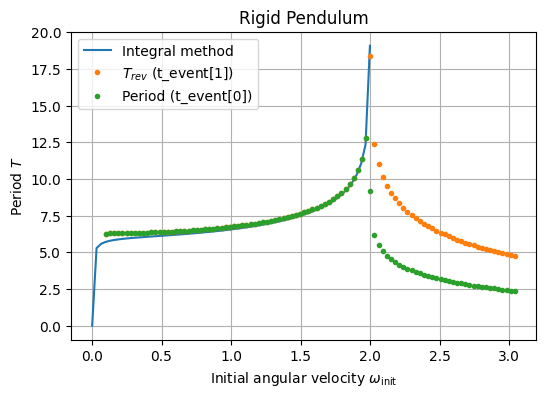

In [44]:
n_points = 100 #Very computational heavy, typically only use 10.
omega_0 = 1    #Natural frequency

omega_init_list_int, T_int = extract_period_int(n_points, omega_0=omega_0)          #integral approach
omega_init_list_ode, T_ode, T_rev_ode = extract_period_ode(n_points,omega_0=omega_0)#solve_ivp approach
plt.figure(figsize=(6,4))
plt.plot(omega_init_list_int, T_int, label="Integral method")
plt.plot(omega_init_list_ode,T_rev_ode, ".", label = "$T_{rev}$ (t_event[1])")
plt.plot(omega_init_list_ode, T_ode, ".", label="Period (t_event[0])")
plt.xlabel(r"Initial angular velocity $\omega_{\mathrm{init}}$")
plt.ylabel("Period $T$")
plt.title("Rigid Pendulum")
plt.legend()
plt.grid(True)
plt.show()


